<a href="https://colab.research.google.com/github/blackbtccollins/AIML_Training/blob/main/class/Blackburn_submission.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Fashion MNIST Competition! - Blackburn Submission
**Author**: T. Blackburn

**Updates**: New Version

## Problem

Classify images from the "Fashion MNIST" data set.   Optimize the test accuracy.

## Metrics

This competition is evaluated on the mean Dice coefficient. The Dice coefficient can be used to compare the pixel-wise agreement between a predicted segmentation and its corresponding ground truth. The formula is given by:![alt text](https://user-images.githubusercontent.com/26015273/41822460-2ca0a90a-77f0-11e8-9c71-7e88fa6b5c61.gif)


The double sum is over the observations `i`, whose number is `N`, and the categories `c`, whose number is `C`. The term `1_{y_i \in C_c}` is the indicator function of the `i`th observation belonging to the `c`th category. The `p_{model}[y_i \in C_c]` is the probability predicted by the model for the `i`th observation to belong to the `c`th category. When there are more than two categories, the neural network outputs a vector of `C` probabilities, each giving the probability that the network input should be classified as belonging to the respective category. When the number of categories is just two, the neural network outputs a single probability `\hat{y}_i`, with the other one being `1` minus the output. This is why the binary cross entropy looks a bit different from categorical cross entropy, despite being a special case of it.

## Dataset

This dataset is the Fashion MNIST dataset

Recently, the researchers at Zalando, an e-commerce company, introduced Fashion MNIST as a drop-in replacement for the original MNIST dataset. Like MNIST, Fashion MNIST consists of a training set consisting of 60,000 examples belonging to 10 different classes and a test set of 10,000 examples. Each training example is a gray-scale image, 28x28 in size. The authors of the work further claim that the Fashion MNIST should actually replace MNIST dataset for benchmarking of new Machine Learning or Computer Vision models.

Each image is 28 pixels in height and 28 pixels in width, for a total of 784 pixels in total. Each pixel has a single pixel-value associated with it, indicating the lightness or darkness of that pixel, with higher numbers meaning darker. This pixel-value is an integer between 0 and 255. The training and test data sets have 785 columns. The first column consists of the class labels (see above), and represents the article of clothing. The rest of the columns contain the pixel-values of the associated image.

The Labels are:  
0 T-shirt/top
1 Trouser
2 Pullover
3 Dress
4 Coat
5 Sandal
6 Shirt
7 Sneaker
8 Bag
9 Ankle boot 

## Objective

In this competition, you can try different variations of the CNN model given as a reference, you may evaluate techniques to squeeze more performance out of a CNN, or you might even try a completely different model, neural network or otherwise.  You will note that there are tips/tricks/techniques documented in many locations on the internet that could be useful.

## Rules and Timeline

The primary measure for the competition will be the accuracy of prediction on the test data.  Ties will be broken by Precision accuracy first, then Recall Accuracy if needed.

The results will be revealed at the end of the last day of class.  Please submit your Metrics blocks (Starts with SUBMIT... and ends with END SUBMISSION) to instructors (wtnewman@raytheon.com) before lunch.

A prize will be given to the top finisher(s) based on the judgement of the instructor and the availability of prizes.


In [39]:
from tensorflow import keras
from keras.datasets import fashion_mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten,  Conv2D, MaxPooling2D, Activation, BatchNormalization
from keras import backend as K
from keras.callbacks import EarlyStopping
from sklearn import metrics
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import TensorBoard,  ModelCheckpoint
from keras.layers.advanced_activations import LeakyReLU
import os
%matplotlib inline
os.environ['TF_CPP_MIN_LOG_LEVEL'] = "2"

## Set Up Variables

In [40]:
epochs = 100                 # Number of Training Epochs
num_classes = 10            # This is the number of classes in the Fashion MNIST dataset
batch_size = 200          # This parameter can be adjusted
img_rows, img_cols = 28, 28 # Pixel sizes of the Images in the Dataset

## Gather and Process Fashion MNIST data

1. First, collect the data from Keras (our goal is someday that our organizational data is this easy to get!)
2. Then split into train and test sets.
3. Next we need to process the data into the proper shape for the CNN
4. Then scale the floats to land between 0 and 1.  Often times we use sklearn's MinMaxScaler for this, but in this case we're going for simplicity.
5. Next take the y_train and y_test labels and encode them one-hot.  This will enable the CNN to function.

In [41]:
# Grab the data from the keras repository

mnist_data = fashion_mnist.load_data()
x = mnist_data[0][0]
y = mnist_data[0][1]

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.33, random_state=41)

# Process the date into the right tensor shape.  This is a good practice, but
# usually tensorflow uses channels last (the 'else' here)

if K.image_data_format() == "channels first":
    x_train = x_train.reshape(x_train.shape[0], 1, img_rows, img_cols)
    x_test = x_test.reshape(x_test.shape[0], 1, img_rows, img_cols)
    input_shape = (1, img_rows, img_cols)
else:
    x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, 1)
    x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, 1)
    input_shape = (img_rows, img_cols, 1)
    
#
#  Cast to a 32 bit float and then scale so the value is a float between 0 and 1
    
x_train = x_train.astype("float32")
x_test = x_test.astype("float32")
x_train /= 255
x_test /= 255

#
# Convert Class Vector to Binary Class Matrices (one-hot encoding).
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)
print(y_test.shape)

#
# Function to decode one-hot encoding later on when we want to evaluate performance.
def decode_one_hot(y):
    y_classes = [np.argmax(yi, axis=None, out=None) for yi in y]
    return y_classes

'''

Below we're experimenting with the Keras ImageDataGenerator.  From my experience, if these parameters
are set too aggressively, the loss/accuracy will either never improve or it will take too long to improve.
Below is an example of a complex data augmentation regime.  This is just for reference.  See my more simple
one at the bottom.

    
datagen = ImageDataGenerator(rotation_range=0.5, 
                                 zoom_range=0.1,
                                 featurewise_center=True,
                                 #featurewise_std_normalization=True,
                                 width_shift_range=0.1, 
                                 height_shift_range=0.1, 
                                 shear_range=0.1,
                                 horizontal_flip=True, 
                                 fill_mode="nearest")
'''
#
#  Set up our Image Augmentation Data Generator
#
datagen = ImageDataGenerator(rotation_range=5)
datagen.fit(x_train)

(19800, 10)


## Build the Model

* In this example, we define the below block as a Sequential Model. 
* See the excellent [Keras Documentation](https://keras.io/guides/sequential_model/) on Sequential Models for info.
* Many of these parameters can be experimented with.  The documentation will help you understand how much to experiment.

In [42]:
#
# This is what is known as a Tensorflow (Keras) Sequential model
# We will talk at some level about each of these layer types in class.
#

###Best####

model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3),
                 activation='relu',
                 #kernel_initializer='he_normal',
                 input_shape=input_shape))
model.add(Dropout(0.7))
model.add(Activation('relu'))
model.add(Conv2D(64, kernel_size=(3,3)))
model.add(LeakyReLU(alpha=0.05))
model.add(Dropout(0.6))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Activation('relu'))
model.add(Flatten())
model.add(Dense(800))  
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation="softmax"))

my_callbacks = [ModelCheckpoint('model_out.hdf5', monitor='val_accuracy',  mode='max', save_best_only=True, period=1)]


In [43]:
#
# This is what is known as a Tensorflow (Keras) Sequential model
# We will talk at some level about each of these layer types in class.
#

###BEST - Save ####

#model = Sequential()
#
#model.add(Conv2D(32, kernel_size=(3,3), input_shape=input_shape))
#model.add(Dropout(0.3))
#model.add(Activation('relu'))
#model.add(Conv2D(64, kernel_size=(3,3)))
#model.add(LeakyReLU(alpha=0.05))
#model.add(Dropout(0.2))
#model.add(MaxPooling2D(pool_size=(2,2)))
#model.add(Activation('relu'))
#model.add(Flatten())
#model.add(Dense(100))  
#model.add(Activation('relu'))
#model.add(Dropout(0.1))
#model.add(Dense(num_classes, activation="softmax"))
#
#my_callbacks = [ModelCheckpoint('model_out.hdf5', monitor='acc', save_best_only=True, period=1)]

## Fit and Evaluate the Model

In [44]:
# Flag to determine whether we use Keras' Image augmentation data generator
augmentation = False

#
# Compile the model so we can fit it. Researching loss functions and optimizers
# might be a good thing to do.
#
model.compile(loss=keras.losses.categorical_crossentropy, 
              optimizer=keras.optimizers.Adam(), 
              metrics=['accuracy'])

if not augmentation:
    #
    # Fit the model.  Once the model is trained we'll evaluate the performance.
    print('not using image augmentation')
    hist = model.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(x_test, y_test),
          callbacks=my_callbacks)
else:
# fits the model on batches with real-time data augmentation:
    hist = model.fit_generator(datagen.flow(x_train, y_train, batch_size=batch_size),
                           steps_per_epoch=len(x_train) / batch_size, validation_data=(x_test, y_test),
                           epochs=epochs, verbose=1, callbacks=my_callbacks, workers = 2)


score = model.evaluate(x_test, y_test)

#
# Predict on the test data and pass to metrics function
yhat = np.argmax(model.predict(x_test), axis=-1)
y_dec = decode_one_hot(y_test)

print("\nSUBMIT THIS BLOCK for the Competition\n")
print(metrics.classification_report(y_dec, yhat))
print("Testing Loss:", score[0])
print("Testing Accuracy:", score[1])
print("END SUBMISSION BLOCK\n")

model.summary()



not using image augmentation
Epoch 1/100
201/201 [==============================] - 5s 22ms/step - loss: 0.7144 - accuracy: 0.7448 - val_loss: 0.6952 - val_accuracy: 0.8387
Epoch 2/100
201/201 [==============================] - 4s 21ms/step - loss: 0.4248 - accuracy: 0.8446 - val_loss: 0.4703 - val_accuracy: 0.8672
Epoch 3/100
201/201 [==============================] - 4s 21ms/step - loss: 0.3729 - accuracy: 0.8628 - val_loss: 0.4252 - val_accuracy: 0.8788
Epoch 4/100
201/201 [==============================] - 4s 21ms/step - loss: 0.3384 - accuracy: 0.8749 - val_loss: 0.3833 - val_accuracy: 0.8908
Epoch 5/100
201/201 [==============================] - 4s 21ms/step - loss: 0.3119 - accuracy: 0.8852 - val_loss: 0.3541 - val_accuracy: 0.8969
Epoch 6/100
201/201 [==============================] - 4s 21ms/step - loss: 0.2945 - accuracy: 0.8914 - val_loss: 0.3199 - val_accuracy: 0.8997
Epoch 7/100
201/201 [==============================] - 4s 20ms/step - loss: 0.2788 - accuracy: 0.8959 - val

## Plot the accuracy vs. validation accuracy

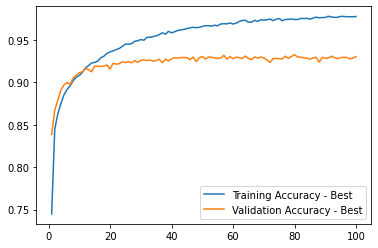

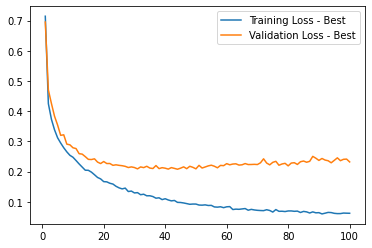

In [45]:
epoch_list = list(range(1, len(hist.history['accuracy']) + 1))
plt.plot(epoch_list, hist.history['accuracy'], epoch_list, hist.history['val_accuracy'])
plt.legend(("Training Accuracy - Best", "Validation Accuracy - Best"))
plt.show()

plt.plot(epoch_list, hist.history['loss'], epoch_list, hist.history['val_loss'])
plt.legend(("Training Loss - Best", "Validation Loss - Best"))
plt.show()

## Extra Test Section

In [46]:
#
# This is what is known as a Tensorflow (Keras) Sequential model
# We will talk at some level about each of these layer types in class.
#

###Test####

model_1 = Sequential()
model_1.add(Conv2D(32, kernel_size=(3, 3),
                 activation='relu',
                 #kernel_initializer='he_normal',
                 input_shape=input_shape))
model_1.add(Dropout(0.6))
model_1.add(Activation('relu'))
model_1.add(Conv2D(64, kernel_size=(3,3)))
model_1.add(LeakyReLU(alpha=0.05))
model_1.add(Dropout(0.5))
model_1.add(MaxPooling2D(pool_size=(2,2)))
model_1.add(Activation('relu'))
model_1.add(Flatten())
model_1.add(Dense(800))  
model_1.add(Activation('relu'))
model_1.add(Dropout(0.4))
model_1.add(Dense(num_classes, activation="softmax"))

my_callbacks_1 = [ModelCheckpoint('model_out.hdf5', monitor='val_accuracy',  mode='max', save_best_only=True, period=1)]

In [47]:
# Flag to determine whether we use Keras' Image augmentation data generator
augmentation = False

#
# Compile the model so we can fit it. Researching loss functions and optimizers
# might be a good thing to do.
#
model_1.compile(loss=keras.losses.categorical_crossentropy, 
              optimizer=keras.optimizers.Adam(), 
              metrics=['accuracy'])

if not augmentation:
    #
    # Fit the model.  Once the model is trained we'll evaluate the performance.
    print('not using image augmentation')
    hist1 = model_1.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(x_test, y_test),
          callbacks=my_callbacks_1)
else:
# fits the model on batches with real-time data augmentation:
    hist1 = model_1.fit_generator(datagen.flow(x_train, y_train, batch_size=batch_size),
                           steps_per_epoch=len(x_train) / batch_size, validation_data=(x_test, y_test),
                           epochs=epochs, verbose=1, callbacks=my_callbacks_1, workers = 2)


score_1 = model_1.evaluate(x_test, y_test)

#
# Predict on the test data and pass to metrics function
yhat = np.argmax(model_1.predict(x_test), axis=-1)
y_dec = decode_one_hot(y_test)

print("\nSUBMIT THIS BLOCK for the Competition\n")
print(metrics.classification_report(y_dec, yhat))
print("Testing Loss:", score_1[0])
print("Testing Accuracy:", score_1[1])
print("END SUBMISSION BLOCK\n")

model_1.summary()

not using image augmentation
Epoch 1/100
201/201 [==============================] - 5s 22ms/step - loss: 0.6224 - accuracy: 0.7785 - val_loss: 0.5353 - val_accuracy: 0.8575
Epoch 2/100
201/201 [==============================] - 4s 21ms/step - loss: 0.3737 - accuracy: 0.8652 - val_loss: 0.3815 - val_accuracy: 0.8849
Epoch 3/100
201/201 [==============================] - 4s 22ms/step - loss: 0.3205 - accuracy: 0.8834 - val_loss: 0.3411 - val_accuracy: 0.8944
Epoch 4/100
201/201 [==============================] - 4s 20ms/step - loss: 0.2852 - accuracy: 0.8945 - val_loss: 0.3337 - val_accuracy: 0.8903
Epoch 5/100
201/201 [==============================] - 4s 21ms/step - loss: 0.2629 - accuracy: 0.9033 - val_loss: 0.2887 - val_accuracy: 0.9049
Epoch 6/100
201/201 [==============================] - 4s 20ms/step - loss: 0.2409 - accuracy: 0.9098 - val_loss: 0.2904 - val_accuracy: 0.9005
Epoch 7/100
201/201 [==============================] - 4s 21ms/step - loss: 0.2232 - accuracy: 0.9153 - val

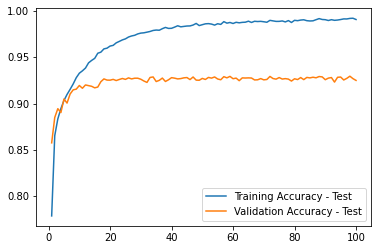

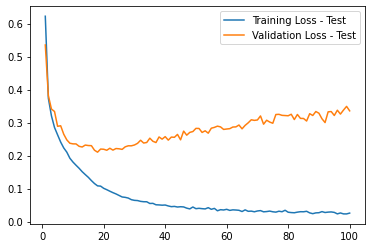

In [48]:
epoch_list_1 = list(range(1, len(hist1.history['accuracy']) + 1))
plt.plot(epoch_list_1, hist1.history['accuracy'], epoch_list_1, hist1.history['val_accuracy'])
plt.legend(("Training Accuracy - Test", "Validation Accuracy - Test"))
plt.show()

plt.plot(epoch_list_1, hist1.history['loss'], epoch_list_1, hist1.history['val_loss'])
plt.legend(("Training Loss - Test", "Validation Loss - Test"))
plt.show()

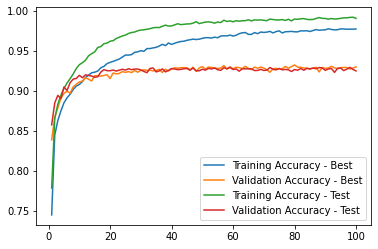

Testing Accuracy - Best: 0.9301515221595764
Testing Accuracy - Test: 0.925000011920929


In [49]:
#Compare

plt.plot(epoch_list, hist.history['accuracy'], epoch_list, hist.history['val_accuracy'])
plt.plot(epoch_list_1, hist1.history['accuracy'], epoch_list_1, hist1.history['val_accuracy'])
plt.legend(("Training Accuracy - Best", "Validation Accuracy - Best", "Training Accuracy - Test", "Validation Accuracy - Test"))
plt.show()

#plt.plot(epoch_list_1, hist1.history['loss'], epoch_list_1, hist1.history['val_loss'])
#plt.legend(("Training Loss - Test", "Validation Loss - Test"))
#plt.show()


print("Testing Accuracy - Best:", score[1])
print("Testing Accuracy - Test:", score_1[1])

## Visualization of Performance on the Test Set

Here is a visualization of how well our classifier can do inference.

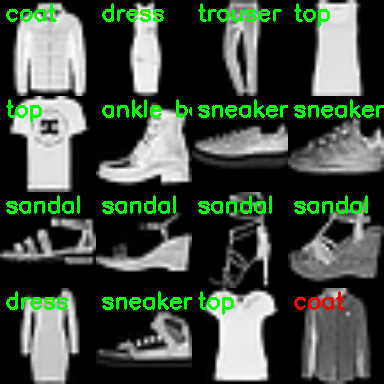

-1

In [50]:
import cv2
from imutils import build_montages
from google.colab.patches import cv2_imshow

# initialize our list of output images
images = []

labelNames = ["top", "trouser", "pullover", "dress", "coat",
	"sandal", "shirt", "sneaker", "bag", "ankle boot"]
 
# randomly select a few testing fashion items
for i in np.random.choice(np.arange(0, len(y_test)), size=(16,)):
	# classify the clothing
	probs = model.predict(x_test[np.newaxis, i])
	prediction = probs.argmax(axis=1)
	label = labelNames[prediction[0]]
 
	# extract the image from the testData if using "channels_first"
	# ordering
	if K.image_data_format() == "channels_first":
		image = (x_test[i][0] * 255).astype("uint8")
 
	# otherwise we are using "channels_last" ordering
	else:
		image = (x_test[i] * 255).astype("uint8")
    # initialize the text label color as green (correct)
	color = (0, 255, 0)
 
	# otherwise, the class label prediction is incorrect
	if prediction[0] != np.argmax(y_test[i]):
		color = (0, 0, 255)
 
	# merge the channels into one image and resize the image from
	# 28x28 to 96x96 so we can better see it and then draw the
	# predicted label on the image
	image = cv2.merge([image] * 3)
	image = cv2.resize(image, (96, 96), interpolation=cv2.INTER_LINEAR)
	cv2.putText(image, label, (5, 20), cv2.FONT_HERSHEY_SIMPLEX, 0.75,
		color, 2)
 
	# add the image to our list of output images
	images.append(image)
# construct the montage for the images
montage = build_montages(images, (96, 96), (4, 4))[0]
 
# show the output montage
cv2_imshow( montage)
cv2.waitKey(0)

In [51]:

#Need to check 50/200
#epochs = 50                 # Number of Training Epochs
#num_classes = 10            # This is the number of classes in the Fashion MNIST dataset
#batch_size = 200          # This parameter can be adjusted
#img_rows, img_cols = 28, 28 # Pixel sizes of the Images in the Dataset

#Current Best
epochs = 40                 # Number of Training Epochs
num_classes = 10            # This is the number of classes in the Fashion MNIST dataset
batch_size = 300          # This parameter can be adjusted
img_rows, img_cols = 28, 28 # Pixel sizes of the Images in the Dataset

#
# This is what is known as a Tensorflow (Keras) Sequential model
# We will talk at some level about each of these layer types in class.
#

###Test####

model_1 = Sequential()
model_1.add(Conv2D(32, kernel_size=(3, 3),
                 activation='relu',
                 #kernel_initializer='he_normal',
                 input_shape=input_shape))
model_1.add(Dropout(0.7))
model_1.add(Activation('relu'))
model_1.add(Conv2D(64, kernel_size=(3,3)))
model_1.add(LeakyReLU(alpha=0.05))
model_1.add(Dropout(0.6))
model_1.add(MaxPooling2D(pool_size=(2,2)))
model_1.add(Activation('relu'))
model_1.add(Flatten())
model_1.add(Dense(1000))  
model_1.add(Activation('relu'))
model_1.add(Dropout(0.5))
model_1.add(Dense(num_classes, activation="softmax"))

my_callbacks = [ModelCheckpoint('model_out.hdf5', monitor='acc', save_best_only=True, period=1)]


#Testing Accuracy - Test: 0.9271717071533203